In [ ]:
#@title Install packages { display-mode: "form" }
%%capture
# !pip install geopandas
# !pip install folium
!pip install geemap
!pip install pandas
!pip install numpy

In [ ]:
# Import libraries
# import geemap
import ee
import folium

import pandas as pd
import numpy  as np
# from pprint import pprint
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%b %y")

import seaborn as sb
from scipy.stats import linregress

from datetime import datetime, timedelta # needed for datetime.strptime
import datetime as dt # check whether I need this

from google.colab import files
import io

# To access DAHITI from API
import requests
import json
import pprint


In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
# Trigger the authentication flow.
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=LTBfU-BktYlmgV-QGr2XPngfNCYCEQQ40kMv7IQ_pIQ&tc=njGlCEbbIO2EqP_kfUnv3UKxUfKrzMBgMx84in5VzTE&cc=KACENl8IDZZTeVZVDDDfRfN-HAWSkXGppORbBooAaIE

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXm2xa7WMPp6Ap7vT9DS9Dld-mdi3WeGfoJkU6JqzaxvSdPVYx8LPqQ

Successfully saved authorization token.


# Functions

In [ ]:
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

def get_s2_sr_cld_col(aoi, start_date, end_date):
    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focal_min(2).focal_max(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)

def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select(['QA60', 'B1','B2','B3','B4','B5','B6','B7','B8','B8A', 'B9', 'B11','B12'])\
              .updateMask(not_cld_shdw);


def add_cloud_percentage(img):

  cloudmask = img.select('cloudmask')
  cloud_area = cloudmask.eq(1).multiply(ee.Image.pixelArea()).rename('cloud_area')#.divide(1000000)
  total_area = cloudmask.eq(1).Or(cloudmask.eq(0)).multiply(ee.Image.pixelArea()).rename('total_area')#.divide(1000000)

  area = cloud_area.addBands(total_area).reduceRegion(
    geometry = aoi,\
    reducer = ee.Reducer.sum(),\
    scale = 10,\
    maxPixels = 20000000000,\
    tileScale = 16
  )

  perc = ee.Number(area.get('cloud_area')).divide(ee.Number(area.get('total_area')))

  return img.set('cloud_perc', perc)


def add_water_extent (img):
  # calculate water extent based on MNDWI and NDWI thresholds
  water_MNDWI = img.select('MNDWI').gte(0).rename('water_MNDWI')
  water_NDWI = img.select('NDWI').lte(0).rename('water_NDWI')
  water = water_MNDWI.Or(water_NDWI).rename('water')

  water_area = water.multiply(ee.Image.pixelArea()).divide(1000000)

  water_extent = water_area.reduceRegion(\
    geometry = aoi,\
    reducer= ee.Reducer.sum(),\
    scale= 10,\
    maxPixels= 20000000000,\
    tileScale= 16\
  ).get('water')

  return img.addBands(water_MNDWI).addBands(water_NDWI).addBands(water)\
                .set('water_extent', water_extent)\
                .set('date', ee.Image(img).date().format('YYYY-MM-dd'))

def convert_imgCol_to_clientDict(imgCol, propNames_list):
  n = len(propNames_list)
  propVals = imgCol.reduceColumns(reducer = ee.Reducer.toList().repeat(n), selectors = propNames_list).get('list');
  dict_EE = ee.Dictionary.fromLists(propNames_list, propVals);
  clientDict = dict_EE.getInfo();

  return clientDict

# AOI

## SELECT AOI

*   'Tabqa'
*   'Tishreen'


In [ ]:
AOI_name = 'Tabqa'

## AOI parameters

#### Points and Polgyons for the reservoirs

In [ ]:
dam_Tishrin = ee.Geometry.Point([38.17848300813228, 36.380737152690656])
dam_Tabqa = ee.Geometry.Point([38.56510446209167, 35.870972690621606])

AOI_Tishrin = ee.Geometry.Polygon([[[38.010548494142455, 36.77219104042317],\
          [38.01569839600435, 36.74110824284246],\
          [38.026176043583746, 36.73367716123688],\
          [38.036649936886825, 36.713587869904266],\
          [38.05072899823461, 36.69652043842134],\
          [38.05930093279661, 36.6568744618735],\
          [38.12523045780217, 36.655512147126174],\
          [38.192511492994484, 36.629602547847256],\
          [38.21019180731715, 36.62946544648836],\
          [38.220320960050884, 36.64034714332425],\
          [38.21843376953154, 36.658387455299525],\
          [38.21036454323464, 36.67477505064971],\
          [38.172598576085775, 36.680832692000756],\
          [38.11903965180163, 36.68964304884765],\
          [38.099815185832384, 36.68936793032813],\
          [38.09552421465149, 36.70010393247643],\
          [38.090886883719875, 36.722672753019154],\
          [38.08814355046176, 36.73340056056873],\
          [38.07724271024235, 36.74990858376371],\
          [38.074407177125046, 36.75761400853883],\
          [38.0593008500423, 36.77659110765869]]]);


AOI_Assad = ee.Geometry.Polygon(\
        [[[38.195303453856226, 36.3722378548376],\
          [38.16852427905154, 36.3755550285924],\
          [38.159597887449976, 36.34569537289177],\
          [38.15753795092654, 36.31969708973381],\
          [38.165091051512476, 36.29590382756327],\
          [38.14655162280154, 36.28538821314512],\
          [38.082693590574976, 36.26158448484893],\
          [38.07514048998904, 36.23943496702787],\
          [38.0456147331531, 36.19456296758793],\
          [38.00441600268435, 36.1452294991273],\
          [38.005102648192164, 36.076998438564786],\
          [38.05385447924685, 36.01148530930804],\
          [38.14174510424685, 35.93090726964557],\
          [38.192556871824976, 35.92145480360175],\
          [38.222769274168726, 35.89809680848627],\
          [38.23993541186404, 35.87083710023906],\
          [38.31958629077029, 35.851916687249656],\
          [38.324392809324976, 35.830208299803836],\
          [38.2818207878406, 35.799583811941865],\
          [38.302420153074976, 35.77451862838928],\
          [38.342932238035914, 35.79401445428721],\
          [38.367651476317164, 35.7695046431874],\
          [38.389624132567164, 35.78120345021648],\
          [38.38001109545779, 35.80849397212792],\
          [38.390310778074976, 35.82241409632645],\
          [38.408850206785914, 35.79679918191409],\
          [38.431509508543726, 35.80515277918743],\
          [38.4740815300281, 35.800697636624506],\
          [38.5125336784656, 35.82575456297234],\
          [38.529699816160914, 35.841341548320855],\
          [38.568151964598414, 35.85247323444601],\
          [38.593557848387476, 35.85247323444601],\
          [38.61347056811404, 35.86471628438131],\
          [38.662222399168726, 35.84690758669498],\
          [38.694494738035914, 35.836888436389835],\
          [38.755606188231226, 35.850247022221964],\
          [38.765905870848414, 35.87640106802499],\
          [38.72951365893435, 35.89475938916923],\
          [38.71509410327029, 35.87695744331241],\
          [38.689001573973414, 35.86861140371863],\
          [38.66908885424685, 35.866942090302544],\
          [38.631323351317164, 35.88029561297686],\
          [38.581884874754664, 35.895315635493176],\
          [38.5619721550281, 35.90477122499329],\
          [38.5619726618351, 35.91478145035245],\
          [38.552359117918726, 35.92145480360177],\
          [38.530386461668726, 35.91589400165712],\
          [38.486441149168726, 35.920898741],\
          [38.45966197436404, 35.959813680125436],\
          [38.434945208114726, 35.9695410805609],\
          [38.408850206785914, 35.97481860670017],\
          [38.39889350263787, 35.96398042518267],\
          [38.40541697924685, 35.94313819535185],\
          [38.392370714598414, 35.93368719167254],\
          [38.338125719481226, 35.967594368381974],\
          [38.2653412956531, 35.99648735470795],\
          [38.20148326342654, 36.045359072283034],\
          [38.14723826830935, 36.06867352305101],\
          [38.1170258659656, 36.088651839834526],\
          [38.110159410887476, 36.13025702731604],\
          [38.14174510424685, 36.17627440532917],\
          [38.13075877612185, 36.200104113041334],\
          [38.156851305418726, 36.23168115260231],\
          [38.194616808348414, 36.235004310089046],\
          [38.22414256518435, 36.25272543114413],\
          [38.231009020262476, 36.30199116707763],\
          [38.225515856199976, 36.317484069299304],\
          [38.20148326342654, 36.33352704384245]]]);



#### AOI dictionary

In [ ]:
AOI_dict = {'Tabqa': {'dead_level': 298, 'start': '2017-01-01', 'poi': dam_Tabqa, 'aoi': AOI_Assad, 'dahiti_id': '111', 'number_outliers_regr': 0},
          'Tishreen': {'dead_level': 320, 'start': '2018-11-01', 'poi': dam_Tishrin, 'aoi': AOI_Tishrin, 'dahiti_id': '15347', 'number_outliers_regr': 4}}

start_date_s2 = AOI_dict[AOI_name]['start']
dead_level = AOI_dict[AOI_name]['dead_level']
aoi = AOI_dict[AOI_name]['aoi']
poi = AOI_dict[AOI_name]['poi']


# Get Sentinel-2

In [ ]:
date_today = datetime.today().strftime("%Y-%m-%d")
end_date_s2 = date_today

# Loading and filtering image collections
sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                    .filterDate(start_date_s2, end_date_s2)

sentinel2 = sentinel2.filterBounds(poi)
sentinel2.size().getInfo()

443

In [ ]:
# pprint.pprint(sentinel2.first())

In [ ]:
# print('Time stamp of last image: ',ee.Image(sentinel2.toList(sentinel2.size()).reverse().get(0)).date().format().getInfo())

# Process Sentinel-2


## Remove odd images
These are images that are for example corrupted due to the Sen2Cor issue with dark pixels, i.e. water pixels. Sen2Cor issue leads to band values of exactly 0 or 1.
In rare cases, an image can also contain clouds, if they were not properly detected (cirrus clouds)

In [ ]:
def remove_images(imgCol):
  if AOI_name == 'Tabqa':
    return imgCol\
              .filterMetadata('system:index', 'not_equals', '20171214T081331_20171214T081331_T37SDV')\
              .filterMetadata('system:index', 'not_equals', '20180202T081241_20180202T081331_T37SDV')\
              .filterMetadata('system:index', 'not_equals', '20180202T081241_20180202T081331_T37SDV')\
              .filterMetadata('system:index', 'not_equals', '20180319T080629_20180319T081138_T37SDV')\
              .filterMetadata('system:index', 'not_equals', '20190518T080611_20190518T081906_T37SDV')\
              .filterMetadata('system:index', 'not_equals', '20200517T080609_20200517T081608_T37SDV')\
              .filterMetadata('system:index', 'not_equals', '20200611T080611_20200611T081109_T37SDV')\
              .filterMetadata('system:index', 'not_equals', '20200929T080731_20200929T081242_T37SDV')\
              .filterMetadata('system:index', 'not_equals', '20201208T081321_20201208T081324_T37SDV')\
              .filterMetadata('system:index', 'not_equals', '20220201T081151_20220201T081236_T37SDV')\
              .filterMetadata('system:index', 'not_equals', '20220427T080559_20220427T081229_T37SDV')\
              .filterMetadata('system:index', 'not_equals', '20220601T080611_20220601T081244_T37SDV')\
              .filterMetadata('system:index', 'not_equals', '20220621T080621_20220621T081248_T37SDV')\
              .filterMetadata('system:index', 'not_equals', '20221004T080759_20221004T081234_T37SDV')\
              .filterMetadata('system:index', 'not_equals', '20221024T081009_20221024T081236_T37SDV')

  if AOI_name == 'Tishreen':
    return imgCol\
               .filterMetadata('system:index', 'not_equals', '20220427T080559_20220427T081229_T37SDA')\
               .filterMetadata('system:index', 'not_equals', '20220830T080621_20220830T081249_T37SDA')\
               .filterMetadata('system:index', 'not_equals', '20220328T080609_20220328T081233_T37SDA')\
               .filterMetadata('system:index', 'not_equals', '20220211T081051_20220211T081235_T37SDA')


In [ ]:
sentinel2 = remove_images(sentinel2)

## Remove cloudy images
from the image collection

In [ ]:
AOI = aoi
START_DATE = ee.Date(start_date_s2);
END_DATE = ee.Date(end_date_s2);

CLOUD_FILTER = 50;
CLD_PRB_THRESH = 40;
NIR_DRK_THRESH = 0.19;
CLD_PRJ_DIST = 3.3;
BUFFER = 33;


# Add cloud mask (we don't apply it as we only want to use it to filter out cloudy images)
s2_sr_col = sentinel2.filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER));

s2_sr_cld_col_eval = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)
s2_cloudMaskAdded = s2_sr_cld_col_eval.map(add_cld_shdw_mask)
s2_cloudMaskAdded = s2_cloudMaskAdded.map(lambda img: img.clip(aoi)).map(add_cloud_percentage) # add cloud percentage within AOI the the image as property

# Filter out cloudy images from AOI based on threshold (in %)
cloud_perc_th = 0.01
s2_filtered = s2_cloudMaskAdded.filterMetadata('cloud_perc', 'less_than', cloud_perc_th)

## Fill B11 gaps and calculate indices


In [ ]:
# MNDWI has holes because B11 has holes (masked values)
# fill B11 masked values with 1000 so that MNDWI is negative and we can use water = water_MNDWI.or(water_NDWI) to return only NDWI. If pixel in water_MNDWI is masked, it returns masked, not water_NDWI.
s2_filtered = s2_filtered.map(lambda image: image.addBands(image.select('B11').unmask(1000).rename('B11_filled')))

### calculate indices
s2_filtered = s2_filtered.map(lambda image: image.addBands(image.normalizedDifference(['B3','B11_filled']).rename('MNDWI'))\
                              .addBands(image.normalizedDifference(['B8','B3']).rename('NDWI')))


In [ ]:
s2_filtered_size = s2_filtered.size()
# s2_filtered_size.getInfo()

In [ ]:
# print('Time stamp of last image: ',ee.Image(s2_filtered.toList(sentinel2.size()).reverse().get(0)).date().format().getInfo())

In [ ]:
# s2_filtered.filterDate('2022-06-21', '2022-06-22').first().getInfo()

## Compute surface water extent time series

### Slice image collection
to avoid memory issues when converting to a client side dictionary

In [ ]:
split_size = s2_filtered_size.divide(3).round()
# split_size.getInfo()

In [ ]:
s2_filtered_list = s2_filtered.toList(s2_filtered_size)
s2_filtered_list_sliced_1 = s2_filtered_list.slice(0,split_size)
s2_filtered_list_sliced_2 = s2_filtered_list.slice(split_size, split_size.multiply(2))
s2_filtered_list_sliced_3 = s2_filtered_list.slice(split_size.multiply(2), split_size.multiply(3))
# s2_filtered_list_sliced_1.size().getInfo()

In [ ]:
# s2_filtered_list_sliced_2.size().getInfo()

In [ ]:
# s2_filtered_list_sliced_3.size().getInfo()

In [ ]:
s2_filtered_sliced_1 = ee.ImageCollection(s2_filtered_list_sliced_1)
s2_filtered_sliced_2 = ee.ImageCollection(s2_filtered_list_sliced_2)
s2_filtered_sliced_3 = ee.ImageCollection(s2_filtered_list_sliced_3)

### Compute water extent and add as property to each image

In [ ]:
s2_filtered_1 = s2_filtered_sliced_1.map(add_water_extent)
s2_filtered_2 = s2_filtered_sliced_2.map(add_water_extent)
s2_filtered_3 = s2_filtered_sliced_3.map(add_water_extent)

### Convert from server to client object
This may take some minutes. Has to be done in at least 2-3 steps to avoid memory issues

In [ ]:
propNames = ['date', 'water_extent']
# Convert sliced image collection 1 (EE server) to Python dictionaries (client side)
dict_1 = convert_imgCol_to_clientDict(s2_filtered_1, propNames)

In [ ]:
# Convert sliced image collection 2 (EE server) to Python dictionaries (client side)
dict_2 = convert_imgCol_to_clientDict(s2_filtered_2, propNames)

In [ ]:
# Convert sliced image collection 3 (EE server) to Python dictionaries (client side)
dict_3 = convert_imgCol_to_clientDict(s2_filtered_3, propNames)

# RERUN SCRIPT from here, if needed.

Merge dictionaries to one dictionary and convert to dictionary to Pandas dataframe

In [ ]:
date_list = dict_1['date'] + dict_2['date'] + dict_3['date']
water_ext_list = dict_1['water_extent'] + dict_2['water_extent'] + dict_3['water_extent']

dictt = {'date': date_list, 'water_extent': water_ext_list}

# print(type(dictt), '\n')
# for prop in dictt.keys():
#     print(prop + ':', dictt[prop][0:3])

df = pd.DataFrame(dictt)
# df.head()

In [ ]:
df.tail()

,date,water_extent
229,2023-09-29,488.340043
230,2023-10-04,501.467879
231,2023-10-14,499.742074
232,2023-10-24,391.989282
233,2023-10-29,501.225817


# Process datasets

## Water extent

Check for duplicate dates and drop them

In [ ]:
df['duplicated'] = df['date'].duplicated(keep='first')
# print(df.head())
print('\n', len(df.loc[df['duplicated'] == True]), 'duplicate date(s)')


 0 duplicate date(s)


In [ ]:
# Drop rows with duplicate dates (otherwise there will be an issue with reindexing later on)
if len(df.loc[df['duplicated'] == True]) > 0:
  df = df.drop_duplicates(subset=['date'])
  print(len(df.loc[df['duplicated'] == True]), 'duplicate date(s)')

Convert date (string) into date object

In [ ]:
df['date'] = pd.to_datetime(df['date'])
print(df.dtypes)

date            datetime64[ns]
water_extent           float64
duplicated                bool
dtype: object


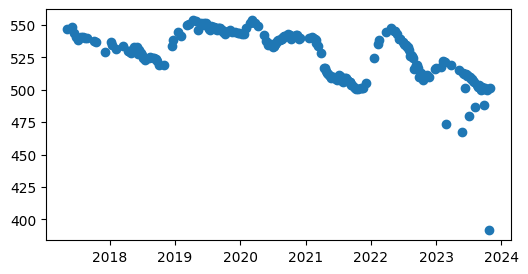

In [ ]:
plt.scatter(df.date, df['water_extent'])


In [ ]:
df.tail(80)

,date,water_extent,duplicated
154,2021-10-04,501.381137,False
155,2021-10-09,500.452244,False
156,2021-10-24,500.469804,False
157,2021-11-08,501.275244,False
158,2021-11-13,501.191135,False
...,...,...,...
229,2023-09-29,488.340043,False
230,2023-10-04,501.467879,False
231,2023-10-14,499.742074,False
232,2023-10-24,391.989282,False


In [ ]:
mages that have bee# Remove outliers manually before interpolating. These outliers are the result of corrputed in examined previously during the process of updating the dataset.
dates = ['2023-02-26', '2023-05-27', '2023-07-06', '2023-08-05', '2023-06-11','2023-08-30', '2023-09-09','2023-09-29', '2023-10-14', '2023-10-24'] # Tabqa model Nov 2023
# dates = ['2022-02-06', '2023-02-26', '2023-05-27', '2023-07-06', '2023-08-05', '2023-06-11','2023-08-30', '2023-09-09','2023-09-29', '2023-10-14', '2023-10-24'] # Tishreen model Nov 2023
for date in dates:
  print(date)
  df = df.loc[df["date"] != date]

2023-02-26
2023-05-27
2023-07-06
2023-08-05
2023-06-11
2023-08-30
2023-09-09
2023-09-29
2023-10-14
2023-10-24


In [ ]:
df.tail(60)

,date,water_extent,duplicated
164,2022-03-28,544.890669,False
165,2022-04-22,547.979428,False
166,2022-05-12,545.432185,False
167,2022-05-17,545.441133,False
168,2022-05-27,542.898424,False
169,2022-06-06,538.962684,False
170,2022-06-11,539.474325,False
171,2022-06-16,539.475161,False
172,2022-07-01,536.756640,False
173,2022-07-06,535.414524,False


Set date as index and fill on daily basis

In [ ]:
df_water_extent = df[['date','water_extent']]
date_range = pd.date_range(start=df_water_extent.date.min(), end = df_water_extent.date.max())

df_water_extent.set_index('date', drop = False, inplace=True) # Set date as index to be able to fill dates
print(df_water_extent.head())

df_water_extent = df_water_extent.reindex(date_range) # Fill dates based on date range
print('\n',df_water_extent.head())

df_water_extent['date'] = df_water_extent.index # Fill date values with index values
print('\n', df_water_extent.head())

                 date  water_extent
date                               
2017-05-08 2017-05-08    547.177893
2017-06-07 2017-06-07    548.891996
2017-06-17 2017-06-17    543.922099
2017-06-27 2017-06-27    540.773313
2017-07-07 2017-07-07    538.597992

                  date  water_extent
2017-05-08 2017-05-08    547.177893
2017-05-09        NaT           NaN
2017-05-10        NaT           NaN
2017-05-11        NaT           NaN
2017-05-12        NaT           NaN

                  date  water_extent
2017-05-08 2017-05-08    547.177893
2017-05-09 2017-05-09           NaN
2017-05-10 2017-05-10           NaN
2017-05-11 2017-05-11           NaN
2017-05-12 2017-05-12           NaN


### Interpolate time series

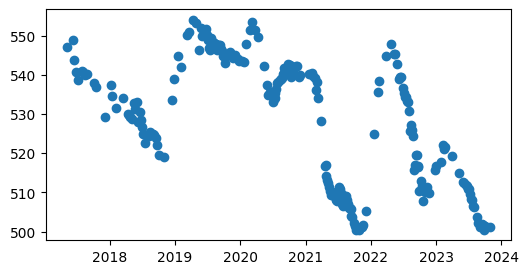

In [ ]:
plt.scatter(df_water_extent.index, df_water_extent['water_extent'])


In [ ]:
df_water_extent['water_extent_interp'] = df_water_extent['water_extent'].interpolate(method ='linear', limit_direction ='forward')
df_water_extent.head()

,date,water_extent,water_extent_interp
2017-05-08,2017-05-08,547.177893,547.177893
2017-05-09,2017-05-09,NaN,547.235030
2017-05-10,2017-05-10,NaN,547.292167
2017-05-11,2017-05-11,NaN,547.349303
2017-05-12,2017-05-12,NaN,547.406440


In [ ]:
df_water_extent.tail(30)

,date,water_extent,water_extent_interp
2023-09-30,2023-09-30,NaN,501.084652
2023-10-01,2023-10-01,NaN,501.180459
2023-10-02,2023-10-02,NaN,501.276266
2023-10-03,2023-10-03,NaN,501.372073
2023-10-04,2023-10-04,501.467879,501.467879
2023-10-05,2023-10-05,NaN,501.458197
2023-10-06,2023-10-06,NaN,501.448514
2023-10-07,2023-10-07,NaN,501.438832
2023-10-08,2023-10-08,NaN,501.429149
2023-10-09,2023-10-09,NaN,501.419467


<Axes: xlabel='date'>

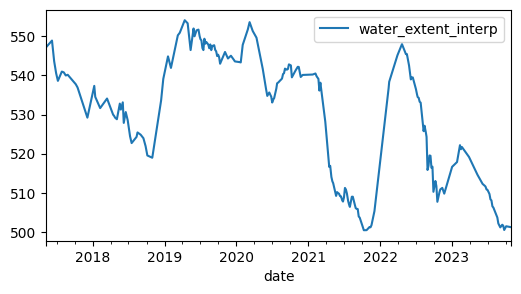

In [ ]:
df_water_extent.plot(x ='date', y='water_extent_interp', kind = 'line')

## DAHITI water level
Fetch from API


In [ ]:
# Enter credentials for DAHITI API 
username = 'xxx'
password = 'xxx'

In [ ]:
#API

url = 'https://dahiti.dgfi.tum.de/api/v1/'
args = {}
""" required options """
args['username'] = username
args['password'] = password
args['action'] = 'download-water-level'
args['dahiti_id'] = AOI_dict[AOI_name]['dahiti_id']

""" send request as method POST """
response = requests.post(url, data=args)

if response.status_code == 200:
	""" convert json string in python list """
	data = json.loads(response.text)
	# pprint.pprint(data)
else:
	print(response.status_code)

In [ ]:
DAHITI_data = data['target']['data'] # List of dictionaries
df_DAHITI = pd.DataFrame(DAHITI_data) # Convert to df
df_DAHITI.tail()

,date,height,error,data_type
192,2023-05-17,299.085,0.006325,OP
193,2023-06-13,298.990,0.002506,OP
194,2023-07-10,298.835,0.000319,OP
195,2023-08-06,298.354,0.000245,OP
196,2023-09-02,298.222,0.001295,OP


In [ ]:
len(df_DAHITI.index)

197

In [ ]:
df_DAHITI.columns

Index(['date', 'height', 'error', 'data_type'], dtype='object')

In [ ]:
df_DAHITI = df_DAHITI.rename(columns = {'height': 'level_DAHITI'}) # rename column
df_DAHITI = df_DAHITI[['date', 'level_DAHITI']]
len(df_DAHITI.index)

197

In [ ]:
df_DAHITI.tail()

,date,level_DAHITI
192,2023-05-17,299.085
193,2023-06-13,298.990
194,2023-07-10,298.835
195,2023-08-06,298.354
196,2023-09-02,298.222


In [ ]:
df_DAHITI.dtypes

date             object
level_DAHITI    float64
dtype: object

In [ ]:
df_DAHITI['date'] = pd.to_datetime(df_DAHITI['date']) # Convert to datetime object
df_DAHITI.dtypes

date            datetime64[ns]
level_DAHITI           float64
dtype: object

In [ ]:
# Set date as index
df_DAHITI.set_index('date', inplace=True)
df_DAHITI.head()

,level_DAHITI
date,
2002-07-31,303.568
2002-09-04,303.276
2002-10-09,303.355
2002-11-13,303.730
2002-12-18,303.290


## In-situ water level
Fetch from Google Drive

In [ ]:
df_in_situ = pd.read_csv('/drive/My Drive/Projects/Water_level_estimates/In_situ/In_situ_water_levels_2021-2023.csv')
df_in_situ.tail()

,Date,Tishreen_level,Tabqa_level,Hurriya_level
58,31-05-23,322.20,299.01,NaN
59,30-06-23,322.15,298.61,NaN
60,31-07-23,322.05,298.25,NaN
61,31-08-23,322.06,297.98,NaN
62,30-09-23,321.83,297.72,NaN


In [ ]:
len(df_in_situ.index)

63

In [ ]:
df_in_situ = df_in_situ.rename(columns = {'Date': 'date'}) # rename column
df_in_situ.tail()

,date,Tishreen_level,Tabqa_level,Hurriya_level
58,31-05-23,322.20,299.01,NaN
59,30-06-23,322.15,298.61,NaN
60,31-07-23,322.05,298.25,NaN
61,31-08-23,322.06,297.98,NaN
62,30-09-23,321.83,297.72,NaN


In [ ]:
df_in_situ = df_in_situ[['date', AOI_name + '_level']]
df_in_situ.tail()

,date,Tabqa_level
58,31-05-23,299.01
59,30-06-23,298.61
60,31-07-23,298.25
61,31-08-23,297.98
62,30-09-23,297.72


In [ ]:
df_in_situ = df_in_situ.dropna() # drops rows with nan values
df_in_situ.tail()

,date,Tabqa_level
58,31-05-23,299.01
59,30-06-23,298.61
60,31-07-23,298.25
61,31-08-23,297.98
62,30-09-23,297.72


In [ ]:
df_in_situ.dtypes

date            object
Tabqa_level    float64
dtype: object

Convert excel date format to datetime object, needs to be in the format 2018-11-10 like water extent to be able to use pd.to_datetime()

In [ ]:
# df_in_situ['date'] = pd.to_datetime(df_in_situ['date']) # does not work with the format

df_in_situ['date_str'] = df_in_situ['date'].astype(str)
df_in_situ['date'] = pd.to_datetime('20' + df_in_situ['date_str'].str[-2:] + '-' + df_in_situ['date_str'].str[3:5] + '-' + df_in_situ['date_str'].str[:2])
del df_in_situ['date_str']

df_in_situ.dtypes

date           datetime64[ns]
Tabqa_level           float64
dtype: object

In [ ]:
df_in_situ.tail()

,date,Tabqa_level
58,2023-05-31,299.01
59,2023-06-30,298.61
60,2023-07-31,298.25
61,2023-08-31,297.98
62,2023-09-30,297.72


In [ ]:
# Set date as index
df_in_situ.set_index('date', inplace=True)
df_in_situ.tail()

,Tabqa_level
date,
2023-05-31,299.01
2023-06-30,298.61
2023-07-31,298.25
2023-08-31,297.98
2023-09-30,297.72


# Linear model

In [ ]:
print(start_date_s2, end_date_s2)

2017-01-01 2023-11-06


In [ ]:
print('How many observations can be used from the DAHITI dataset?')
print(len(df_DAHITI.loc[(df_DAHITI.index > start_date_s2) & (df_DAHITI.index <= end_date_s2)]), 'out of', len(df_DAHITI))

How many observations can be used from the DAHITI dataset?
106 out of 197


### Join DAHITI to water extent

In [ ]:
df_matched_corr = df_DAHITI.join(df_water_extent)
df_matched_corr.tail()

,level_DAHITI,date,water_extent,water_extent_interp
date,,,,
2023-05-17,299.085,2023-05-17,NaN,514.066124
2023-06-13,298.990,2023-06-13,NaN,511.996222
2023-07-10,298.835,2023-07-10,NaN,509.805089
2023-08-06,298.354,2023-08-06,NaN,505.473261
2023-09-02,298.222,2023-09-02,NaN,501.378281


In [ ]:
len(df_matched_corr.index)

197

In [ ]:
del df_matched_corr['water_extent'] # only keep interpolated water extent, and drop the original column

In [ ]:
df_matched_corr.tail()

,level_DAHITI,date,water_extent_interp
date,,,
2023-05-17,299.085,2023-05-17,514.066124
2023-06-13,298.990,2023-06-13,511.996222
2023-07-10,298.835,2023-07-10,509.805089
2023-08-06,298.354,2023-08-06,505.473261
2023-09-02,298.222,2023-09-02,501.378281


In [ ]:
len(df_matched_corr.index)

197

In [ ]:
df_matched_corr = df_matched_corr.dropna() # drop rows with no data # .dropna(axis='columns') (earlier dates than Sentinel-2)
len(df_matched_corr.index)

102

In [ ]:
print('Number of matched observations: ', len(df_matched_corr))

Number of matched observations:  102


### Calculate the model
w_level = w_extent*x + b

In [ ]:
values = df_matched_corr[["water_extent_interp", "level_DAHITI"]].to_numpy()
slope, intercept, r_value, p_value, std_err = linregress(values[:,0], values[:,1])

r_sq = round(r_value*r_value, 4)
p_val = round(p_value, 2)
SE = round(std_err, 6)
slope_rounded = round(slope, 2)
interc = round(intercept, 2)

In [ ]:
if p_val >= 0.05: p_sig = ''
if p_val < 0.05: p_sig = '*'
if p_val < 0.01: p_sig = '**'
if p_val < 0.001: p_sig = '***'

print('Slope', slope_rounded)
print('Intercept', interc)
print('Standard error', SE)
print('r squared', r_sq)
print('p_value ', p_value)
print('p significance: ', p_sig)

Slope 0.13
Intercept 231.03
Standard error 0.003223
r squared 0.9443
p_value  1.5787609188733555e-64
p significance:  ***


In [ ]:
# length = len(df_matched_corr.index)
# first_date = df_matched_corr.iloc[0]['date'].strftime('%Y-%m-%d')
# last_date = df_matched_corr.iloc[length-1]['date'].strftime('%Y-%m-%d')
# print('Last date in df: ', last_date)

### Remove outliers if neccessary


predicted level = interecept + slope * interpolated water extent

In [ ]:
df_matched_corr['level_predicted'] = intercept + slope *  df_matched_corr['water_extent_interp']
df_matched_corr.head()

,level_DAHITI,date,water_extent_interp,level_predicted
date,,,,
2017-05-21,303.982,2017-05-21,547.920671,303.749541
2017-06-17,303.535,2017-06-17,543.922099,303.218871
2017-08-10,302.862,2017-08-10,540.449063,302.757947
2017-09-06,302.740,2017-09-06,539.510799,302.633426
2017-10-03,302.918,2017-10-03,537.939355,302.424872


residual = actual level-predicted level

In [ ]:
df_matched_corr['residual'] = df_matched_corr['level_DAHITI'] - df_matched_corr['level_predicted']
df_matched_corr.head()

,level_DAHITI,date,water_extent_interp,level_predicted,residual
date,,,,,
2017-05-21,303.982,2017-05-21,547.920671,303.749541,0.232459
2017-06-17,303.535,2017-06-17,543.922099,303.218871,0.316129
2017-08-10,302.862,2017-08-10,540.449063,302.757947,0.104053
2017-09-06,302.740,2017-09-06,539.510799,302.633426,0.106574
2017-10-03,302.918,2017-10-03,537.939355,302.424872,0.493128


Print the rows with the largest residuals

In [ ]:
df_matched_corr_sorted = df_matched_corr.copy()
df_matched_corr_sorted = df_matched_corr_sorted.reindex(df_matched_corr_sorted.residual.abs().sort_values().index)
df_matched_corr_sorted.tail(10)

,level_DAHITI,date,water_extent_interp,level_predicted,residual
date,,,,,
2017-10-30,302.725,2017-10-30,534.598762,301.981525,0.743475
2022-02-12,301.431,2022-02-12,536.151856,302.187644,-0.756644
2019-11-25,304.105,2019-11-25,544.594709,303.308137,0.796863
2019-12-22,303.992,2019-12-22,543.742295,303.195009,0.796991
2019-03-27,303.384,2019-03-27,551.914941,304.279641,-0.895641
2019-09-16,304.464,2019-09-16,546.439707,303.552995,0.911005
2019-12-21,304.200,2019-12-21,543.830314,303.206690,0.993310
2020-10-14,303.746,2020-10-14,539.977484,302.695362,1.050638
2019-12-16,304.322,2019-12-16,544.208305,303.256855,1.065145


Number of rows to be dropped are pulled from AOI dictionary.
For Tishreen drop residuals > 1 (n = 4 on 11 Jan 2023), for Tabqa not necessary

In [ ]:
df_machted_outliersRemoved = df_matched_corr_sorted.copy()
# Number of rows to drop
n = AOI_dict[AOI_name]['number_outliers_regr']
print('Number of rows dropped:', n)
# Dropping last n rows using drop
df_machted_outliersRemoved.drop(df_machted_outliersRemoved.tail(n).index, inplace = True)

Number of rows dropped: 0


In [ ]:
df_machted_outliersRemoved.tail()

,level_DAHITI,date,water_extent_interp,level_predicted,residual
date,,,,,
2019-09-16,304.464,2019-09-16,546.439707,303.552995,0.911005
2019-12-21,304.200,2019-12-21,543.830314,303.206690,0.993310
2020-10-14,303.746,2020-10-14,539.977484,302.695362,1.050638
2019-12-16,304.322,2019-12-16,544.208305,303.256855,1.065145
2017-11-26,302.543,2017-11-26,530.436578,301.429141,1.113859


### Recaculate model and plot

In [ ]:
df_lin_regr = df_machted_outliersRemoved

In [ ]:
values = df_lin_regr[["water_extent_interp", "level_DAHITI"]].to_numpy()
slope, intercept, r_value, p_value, std_err = linregress(values[:,0], values[:,1])

r_sq = round(r_value*r_value, 4)
p_val = round(p_value, 2)
SE = round(std_err, 6)
slope_rounded = round(slope, 2)
interc = round(intercept, 2)

In [ ]:
if p_val >= 0.05: p_sig = ''
if p_val < 0.05: p_sig = '*'
if p_val < 0.01: p_sig = '**'
if p_val < 0.001: p_sig = '***'

print('Slope', slope)
print('Intercept', intercept)
print('Standard error', SE)
print('r squared', r_sq)
print('p_value ', p_value)
print('p significance: ', p_sig)

Slope 0.13271493374229787
Intercept 231.03228587457005
Standard error 0.003223
r squared 0.9443
p_value  1.578760918875825e-64
p significance:  ***


In [ ]:
length = len(df_matched_corr.index)
first_date = df_matched_corr.iloc[0]['date'].strftime('%Y-%m-%d')
last_date = df_matched_corr.iloc[length-1]['date'].strftime('%Y-%m-%d')
print('Last date in df: ', last_date)

Last date in df:  2023-09-02


Tabqa_lin_regr_2017-05-21_2023-09-02_red_v2.jpg


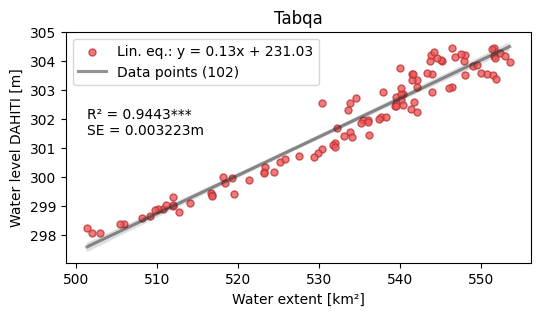

In [ ]:
mpl.rcdefaults()

mpl.rcParams['figure.figsize'] = (6, 3)
# '#EE5859' REACH red

if AOI_name == 'Tabqa': text_location = 3
else: text_location = 2

# sb.regplot(x = "water_extent_interp", y = "level_DAHITI",  data = dataframe_fig, scatter_kws={'color': 'lightgrey', 'edgecolor':'#2b2b2b','alpha':0.7, 's':25}, line_kws={'color': '#2b2b2b', 'alpha':0.7})
sb.regplot(x = "water_extent_interp", y = "level_DAHITI",  data = df_lin_regr, scatter_kws={'color': '#EE5859',  'edgecolor':'#BD3536', 'alpha':0.8, 's':25}, line_kws={'color': '#2b2b2b', 'alpha':0.5})
plt.xlabel("Water extent [km²]")
plt.ylabel("Water level DAHITI [m]")
plt.text(min(values[:,0]), max(values[:,1]-text_location), 'R² = {}{}\nSE = {}m'.format(r_sq, p_sig, SE))
plt.legend(labels=['Lin. eq.: y = {}x + {}'.format(slope_rounded, interc), 'Data points ({})'.format(len(values[:,0]))])
plt.title(AOI_name)

# ### Download figure
file_name = AOI_name+'_lin_regr_' + first_date +'_' + last_date + '_red_v2.jpg'
print(file_name)
plt.savefig(file_name, dpi=300, bbox_inches='tight')
# files.download(file_name)

### Apply the model
Add the predicted water level estimations to the initial dataframe

In [ ]:
df_water_extent['water_level_pred'] = df_water_extent['water_extent'] * slope + intercept
df_water_extent.head()

,date,water_extent,water_extent_interp,water_level_pred
2017-05-08,2017-05-08,547.177893,547.177893,303.650964
2017-05-09,2017-05-09,NaN,547.235030,NaN
2017-05-10,2017-05-10,NaN,547.292167,NaN
2017-05-11,2017-05-11,NaN,547.349303,NaN
2017-05-12,2017-05-12,NaN,547.406440,NaN


Text(0.5, 1.0, 'Surface water extent')

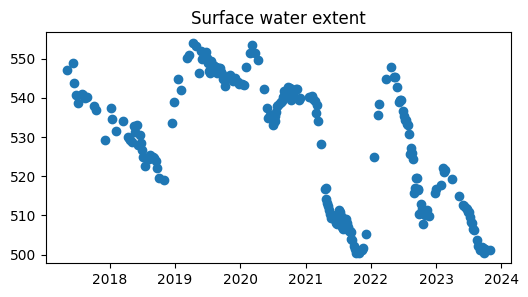

In [ ]:
plt.scatter(df_water_extent.index, df_water_extent['water_extent'])
plt.title('Surface water extent')


Text(0.5, 1.0, 'Water Level Estimations')

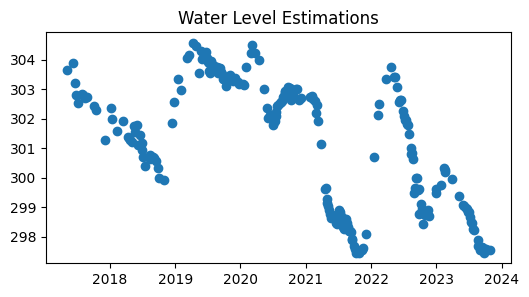

In [ ]:
plt.scatter(df_water_extent.index, df_water_extent['water_level_pred'])
plt.title('Water Level Estimations')

# Results

### Join all datasets

In [ ]:
df_matched = df_water_extent.join(df_in_situ[AOI_name + '_level']).join(df_DAHITI)
df_matched.head()

,date,water_extent,water_extent_interp,water_level_pred,Tabqa_level,level_DAHITI
2017-05-08,2017-05-08,547.177893,547.177893,303.650964,NaN,NaN
2017-05-09,2017-05-09,NaN,547.235030,NaN,NaN,NaN
2017-05-10,2017-05-10,NaN,547.292167,NaN,NaN,NaN
2017-05-11,2017-05-11,NaN,547.349303,NaN,NaN,NaN
2017-05-12,2017-05-12,NaN,547.406440,NaN,NaN,NaN


In [ ]:
df_matched.tail()

,date,water_extent,water_extent_interp,water_level_pred,Tabqa_level,level_DAHITI
2023-10-25,2023-10-25,NaN,501.264547,NaN,NaN,NaN
2023-10-26,2023-10-26,NaN,501.254864,NaN,NaN,NaN
2023-10-27,2023-10-27,NaN,501.245182,NaN,NaN,NaN
2023-10-28,2023-10-28,NaN,501.235499,NaN,NaN,NaN
2023-10-29,2023-10-29,501.225817,501.225817,297.552437,NaN,NaN


### Plot all datasets
Compare estimated water levels with secondary Altimetry (water level) data (DAHITI) and in-situ data

In [ ]:
bbox_props = dict(boxstyle="square", fc="w", ec="0.5")

In [ ]:
label_pos_x = pd.to_datetime(AOI_dict[AOI_name]['start']) + timedelta(days=30*12*3)
label_pos_x

Timestamp('2019-12-17 00:00:00')

In [ ]:
labels = ['DAHITI estimates', 'Sentinel-2 estimates', 'Measurements by dam authorities']

Tabqa_water_level_allSeries_2017-05-21_2023-09-02.jpg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

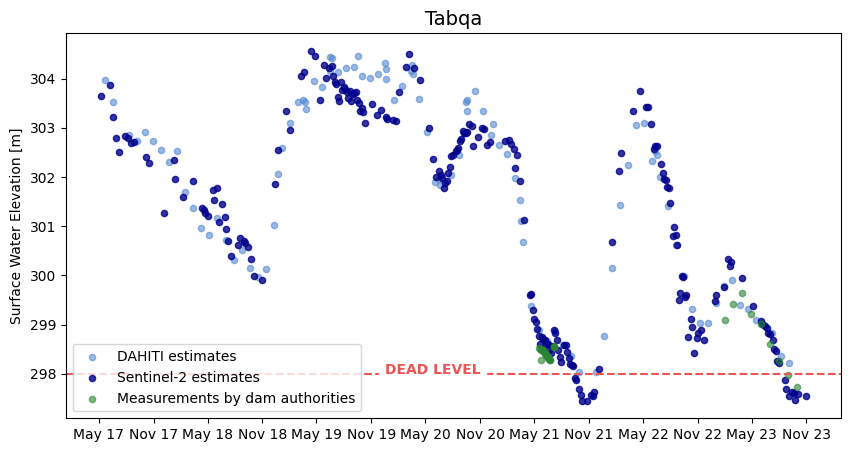

In [ ]:
mpl.rcdefaults()
mpl.rcParams['figure.figsize'] = (10, 5)

ax = plt.gca()
df_matched.plot(x ='date', y='level_DAHITI',color='#5589cf', alpha=0.6, kind = 'scatter',ax=ax, label=labels[0])
df_matched.plot(x ='date', y='water_level_pred', color='darkblue', alpha=0.8, kind = 'scatter',ax=ax, label=labels[1])
df_matched.plot(x ='date', y=AOI_name + '_level',  color='#298534',  alpha=0.6, kind = 'scatter',ax=ax, label=labels[2])

plt.ylabel("Surface Water Elevation [m]")
plt.axhline(y = dead_level, color = '#EB5556', linestyle = 'dashed')

plt.title(AOI_name, fontsize=14)
# plt.text(label_pos_x, dead_level, "Dead Level", backgroundcolor = 'white', bbox=bbox_props)
plt.text(label_pos_x, dead_level, "DEAD LEVEL", color = '#EB5556',backgroundcolor = 'white',weight='bold')
# plt.xlim(pd.to_datetime('01-04-17'), pd.to_datetime('31-12-21')) ## for Tabqa , otherwise comment out.
# plt.xticks(rotation=90)
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.label.set_visible(False)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.legend(loc='lower left')
# Download figure (uncomment plt show)
file_name = AOI_name + '_water_level_allSeries_'+first_date+ '_' + last_date +'.jpg'
print(file_name)
plt.savefig(file_name, dpi=300)

files.download(file_name)

Zoom in to time period where in-situ data exists

Tabqa_water_level_allSeries_zoom_2021-05-01_2023-09-02.jpg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

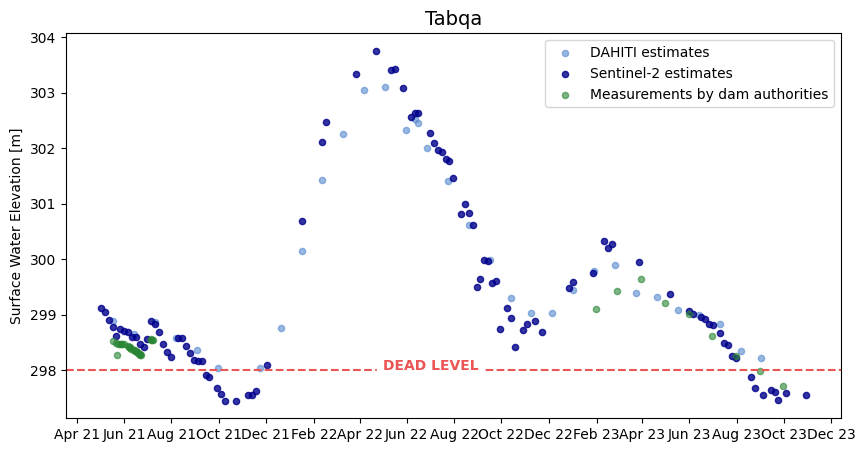

In [ ]:
# mpl.rcParams['figure.figsize'] = (9, 6)
start_date = '2021-05-01'
df_masked = df_matched.loc[(df_matched['date'] > start_date) & (df_matched['date'] <= end_date_s2)]

ax = plt.gca()
df_masked.plot(x ='date', y='level_DAHITI',color='#5589cf', alpha=0.6, kind = 'scatter',ax=ax, label=labels[0])
df_masked.plot(x ='date', y='water_level_pred', color='darkblue', alpha=0.8, kind = 'scatter',ax=ax, label=labels[1])
df_masked.plot(x ='date', y=AOI_name + '_level',  color='#298534',  alpha=0.6, kind = 'scatter',ax=ax, label=labels[2])


ax.legend()
plt.ylabel("Surface Water Elevation [m]")
# plt.xlabel("Time")
plt.axhline(y = dead_level, color = '#EB5556', linestyle = 'dashed')
# plt.text(pd.to_datetime('2021-05-01'), dead_level, "Dead Level", backgroundcolor = 'white', bbox=bbox_props)
plt.text(pd.to_datetime('2022-05-01'), dead_level, "DEAD LEVEL", color = '#EB5556',backgroundcolor = 'white',weight='bold')
# plt.xticks(rotation=90)
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.label.set_visible(False)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.title(AOI_name, fontsize=14)
# plt.show()

# Download figure (uncomment plt show)
file_name = AOI_name + '_water_level_allSeries_zoom_'+start_date+ '_' + last_date +'.jpg'
print(file_name)
plt.savefig(file_name, dpi=300)

files.download(file_name)


# Validation

### How much do our estimates deviate from the DAHITI estimates?

In [ ]:
# interpolate water level estimations
df_water_extent['water_level_pred_interp'] = df_water_extent['water_level_pred'].interpolate(method ='linear', limit_direction ='forward')

# join DAHITI
df_dev = df_water_extent.join(df_DAHITI)[['level_DAHITI', 'water_level_pred_interp']].dropna()
print('Number of matched observations: ', len(df_dev))

#compute differene between interpolated water level estimations and DAHITI
df_dev['diff'] = df_dev['water_level_pred_interp'] - df_dev['level_DAHITI']

mean = df_dev['diff'].mean()
print(mean)
mean_str = str(mean)[0:5] + str(mean)[-4:]

Number of matched observations:  102
3.622374731326001e-14


Calculate mean of all **absolute** deviations (mean absolute error, MAE)

In [ ]:
mean_dev = df_dev['diff'].abs().mean()
mean_dev

0.37528685556864727

Tabqa_abs_dev_histo_estimated_DAHITI.jpg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

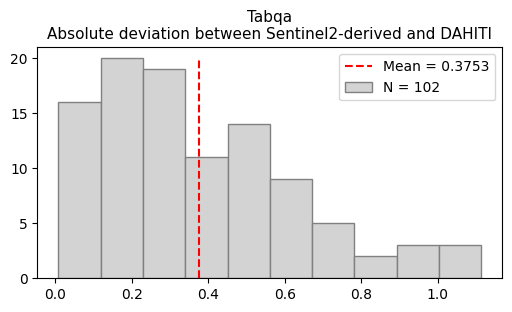

In [ ]:
mpl.rcdefaults()
mpl.rcParams['figure.figsize'] = (6, 3)

y, x, _ = plt.hist(df_dev['diff'].abs(), color='lightgrey',edgecolor = 'grey')
plt.vlines(mean_dev,0,y.max(), colors='red',linestyles='dashed')

plt.legend(['Mean = {}'.format(round(mean_dev,4)),'N = {}'.format(len(df_dev['diff']))])
plt.title(AOI_name+'\nAbsolute deviation between Sentinel2-derived and DAHITI', fontsize=11)

# Download figure (uncomment plt show)
file_name = AOI_name + '_abs_dev_histo_estimated_DAHITI'+'.jpg'
print(file_name)
plt.savefig(file_name, dpi=200)

files.download(file_name)

### How much do our estimates deviate from the official measurements?
We are restricted to a very short time window here

In [ ]:
df_dev = df_water_extent.join(df_in_situ[AOI_name + '_level'])[[AOI_name + '_level', 'water_level_pred_interp']].dropna()
print('Number of matched observations: ', len(df_dev))

df_dev['diff'] = df_dev['water_level_pred_interp'] - df_dev[AOI_name + '_level']
df_dev.tail()

Number of matched observations:  37


,Tabqa_level,water_level_pred_interp,diff
2023-05-31,299.01,299.086546,0.076546
2023-06-30,298.61,298.820083,0.210083
2023-07-31,298.25,298.216928,-0.033072
2023-08-31,297.98,297.599769,-0.380231
2023-09-30,297.72,297.533702,-0.186298


Calculate mean of all **absolute** deviations

In [ ]:
mean_dev = df_dev['diff'].abs().mean()
mean_dev

0.2646539734601453

Tabqa_abs_dev_histo_estimated_groundObs.jpg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

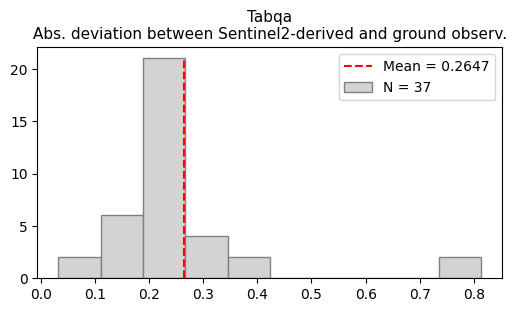

In [ ]:
mpl.rcdefaults()
mpl.rcParams['figure.figsize'] = (6, 3)

y, x, _ = plt.hist(df_dev['diff'].abs(), color='lightgrey',edgecolor = 'grey')
plt.vlines(mean_dev,0,y.max(), colors='red',linestyles='dashed')

plt.legend(['Mean = {}'.format(round(mean_dev,4)),'N = {}'.format(len(df_dev['diff']))])
plt.title(AOI_name + '\nAbs. deviation between Sentinel2-derived and ground observ.', fontsize=11)

# Download figure (uncomment plt show)
file_name = AOI_name + '_abs_dev_histo_estimated_groundObs'+'.jpg'
print(file_name)
plt.savefig(file_name, dpi=200)

files.download(file_name)

Regress our estimates with official measurements

In [ ]:
values_ = df_dev[["water_level_pred_interp", AOI_name + '_level']].to_numpy()
slope, intercept, r_value, p_value, std_err = linregress(values_[:,0], values_[:,1])

r_sq = round(r_value*r_value, 4)
p_val = round(p_value, 2)
SE = round(std_err, 6)
slope_rounded = round(slope, 2)
interc = round(intercept, 2)

In [ ]:
if p_val >= 0.05: p_sig = ''
if p_val < 0.05: p_sig = '*'
if p_val < 0.01: p_sig = '**'
if p_val < 0.001: p_sig = '***'

print('Slope', slope)
print('Intercept', interc)
print('Standard error', SE)
print('r squared', r_sq)
print('p_value ', p_value)
print('p significance: ', p_sig)

Slope 0.6823078360787659
Intercept 94.67
Standard error 0.036865
r squared 0.9073
p_value  1.1769179010133894e-19
p significance:  ***


Tabqa_regress_estim_ground_2017-05-21_2023-09-02_grey.jpg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

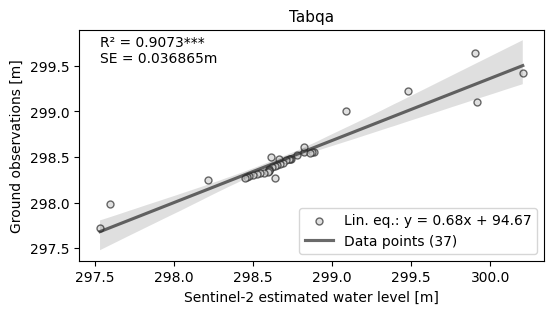

In [ ]:
mpl.rcdefaults()
mpl.rcParams['figure.figsize'] = (6, 3)
# scatter_kws={'color': '#EE5859',  'edgecolor':'#BD3536', 'alpha':0.8, 's':25}, line_kws={'color': '#2b2b2b', 'alpha':0.5})
sb.regplot(x = 'water_level_pred_interp', y = AOI_name + '_level',  data = df_dev,  scatter_kws={'color': 'lightgrey', 'edgecolor':'#2b2b2b','alpha':0.7, 's':25}, line_kws={'color': '#2b2b2b', 'alpha':0.7})
plt.xlabel("Sentinel-2 estimated water level [m]")
plt.ylabel("Ground observations [m]")

plt.text(np.amin(values_[:,0]), np.amax(values_[:,1]-0.1), 'R² = {}{}\nSE = {}m'.format(r_sq, p_sig, SE))

plt.legend(labels=['Lin. eq.: y = {}x + {}'.format(slope_rounded, interc), 'Data points ({})'.format(len(values_[:,0]))],loc='lower right')
plt.title(AOI_name , fontsize=11)

### Download figure
file_name = AOI_name+'_' + 'regress_estim_ground_'+ first_date +'_' + last_date + '_grey.jpg'
print(file_name)
plt.savefig(file_name, dpi=200, bbox_inches='tight')
files.download(file_name)

# Download table as CSV file

In [ ]:
df_csv = df_matched[['water_level_pred', 'level_DAHITI', AOI_name + '_level']]

column_names = list(df_csv)
print(column_names)

new_column_names = ['Water level [m] (pred.)', 'Water level [m] (DAHITI)', 'Water level [m] (dam auth.)']
print(new_column_names)

df_csv = df_csv.rename(columns={column_names[0]:new_column_names[0],
                                column_names[1]:new_column_names[1],
                                column_names[2]:new_column_names[2]
                                })
df_csv.tail()

['water_level_pred', 'level_DAHITI', 'Tabqa_level']
['Water level [m] (pred.)', 'Water level [m] (DAHITI)', 'Water level [m] (dam auth.)']


,Water level [m] (pred.),Water level [m] (DAHITI),Water level [m] (dam auth.)
2023-10-25,NaN,NaN,NaN
2023-10-26,NaN,NaN,NaN
2023-10-27,NaN,NaN,NaN
2023-10-28,NaN,NaN,NaN
2023-10-29,297.552437,NaN,NaN


In [ ]:
df_csv = df_csv.dropna(how='all')
df_csv.reset_index(inplace=True)
df_csv = df_csv.rename(columns = {'index':'Date'})
df_csv['Date'] = pd.to_datetime(df_csv['Date'])
df_csv['Date'] = df_csv['Date'].dt.strftime("%Y-%m-%d")

In [ ]:
df_csv

,Date,Water level [m] (pred.),Water level [m] (DAHITI),Water level [m] (dam auth.)
0,2017-05-08,303.650964,NaN,NaN
1,2017-05-21,NaN,303.982,NaN
2,2017-06-07,303.878451,NaN,NaN
3,2017-06-17,303.218871,303.535,NaN
4,2017-06-27,302.800980,NaN,NaN
...,...,...,...,...
338,2023-09-19,297.603639,NaN,NaN
339,2023-09-24,297.457412,NaN,NaN
340,2023-09-30,NaN,NaN,297.72
341,2023-10-04,297.584562,NaN,NaN


In [ ]:
df_csv.drop(df_csv.tail(1).index,inplace=True)

In [ ]:
df_csv

,Date,Water level [m] (pred.),Water level [m] (DAHITI),Water level [m] (dam auth.)
0,2017-05-08,303.650964,NaN,NaN
1,2017-05-21,NaN,303.982,NaN
2,2017-06-07,303.878451,NaN,NaN
3,2017-06-17,303.218871,303.535,NaN
4,2017-06-27,302.800980,NaN,NaN
...,...,...,...,...
337,2023-09-14,297.636262,NaN,NaN
338,2023-09-19,297.603639,NaN,NaN
339,2023-09-24,297.457412,NaN,NaN
340,2023-09-30,NaN,NaN,297.72


In [ ]:
file_name = "Water_level_" + AOI_name + '_' + '2023-10-04.csv'
file_name

'Water_level_Tabqa_2023-10-04.csv'

In [ ]:
df_csv.to_csv(file_name )

In [ ]:
from google.colab import files
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Export csv to Google Drive
df_csv.to_csv('/drive/My Drive/Projects/Water_level_estimates/'+AOI_name+'/'+file_name)